In [ ]:
# # This file is part of Theano Geometry
#
# Copyright (C) 2017, Stefan Sommer (sommer@di.ku.dk)
# https://bitbucket.org/stefansommer/theanogemetry
#
# Theano Geometry is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# Theano Geometry is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with Theano Geometry. If not, see <http://www.gnu.org/licenses/>.
#

# LDDMM landmark dynamics

In [3]:
from src.manifolds.landmarks import *
M = landmarks(2)
print(M)

from src.plotting import *

WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


2 landmarks in R^2 (dim 4). kernel Gaussian, k_alpha=1, k_sigma=[[0.5 0. ]
 [0.  0.5]]


In [16]:
# Riemannian structure
from src.Riemannian import metric
metric.initialize(M)

# Hamiltonian dynamics
from src.dynamics import Hamiltonian
Hamiltonian.initialize(M)

In [5]:
# example configuration
M.k_sigma.set_value(tensor(np.diag((.5,.5))))

q = tensor(np.vstack((np.linspace(-.5,.5,M.N.eval()),np.zeros(M.N.eval()))).T.flatten())
v = tensor(np.vstack((np.zeros(M.N.eval()),np.ones(M.N.eval()))).T.flatten())
p = M.flatf(q,v)
print("q = ", q)
print("p = ", p)

q =  [-0.5  0.   0.5  0. ]
p =  [0.         0.88079708 0.         0.88079708]


## Cardiac data

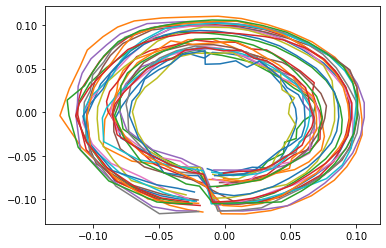

In [78]:
# load data
# load data
DIM = 2
from scipy import io
import sys
import glob

NN = 66
files = glob.glob("/home/stefan/Dropbox/projects/ArHoSo-matching/data/cardiac/*.asf")
K = len(files)
qs = np.zeros((K,NN,DIM))
for j in range(K):
    try:
        in_file = open(files[j], 'r')

        NN = -1
        for line in in_file.readlines():
            if len(line) > 1 and line[0] != '#':
                splits = line.split()
                if NN < 0 and len(splits) == 1:
                    NN = int(splits[0])
                    q = np.zeros((NN,DIM))
                    i = 0
                if len(splits) >= 7:
                    q[i,0] = float(splits[2])
                    q[i,1] = float(splits[3])
                    i = i + 1 
    finally:
        in_file.close()
    qs[j] = q-np.tile(np.mean(q,axis=0),((q.shape[0],1)))

N_samples = qs.shape[0]
# # subsample
# qs = qs[:,0:-1:4,:]
obss = 10*qs.reshape((N_samples,-1))
M.N.set_value(obss.shape[1]/DIM)

%matplotlib inline
for i in range(N_samples):
    plt.plot(qs[i,:,0],qs[i,:,1])

# save
np.save('cardiac.npy',qs)

/home/stefan/Dropbox/projects/ArHoSo-matching/data/cardiac/c4556h_s1.asf


(80.0, 180.0, 70.0, 170.0)

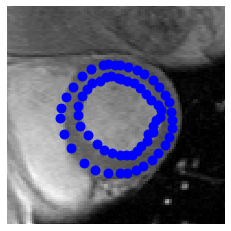

In [79]:
## plot on image with annotations
file = "/home/stefan/Dropbox/projects/ArHoSo-matching/data/cardiac/c4480h_s1.png"
img = plt.imread(file)
plt.imshow(img, cmap='gray')
i = 2
print(files[i])
M.plotx(np.tile(np.array([133,120]),(M.N.eval(),1)).flatten()+255/10*obss[i],markersize=80)
plt.ylim([70,170,]); plt.xlim([80,180,])
plt.axis('off')

## Corpora callosa

(155, 65)
(65, 77, 2)


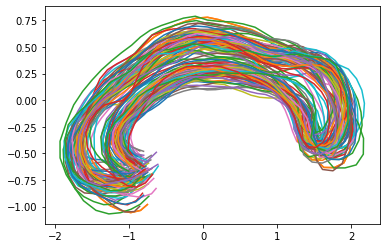

In [80]:
# load data
DIM = 2
from scipy import io
# load CC data...
data=io.loadmat('/home/stefan/projects/diffusion/data/dataM-corpora-callosa-ipmi.mat')

vi = data['vi'] # corpora callosa
Nsamples = vi.shape[1]
N0 = int(vi.shape[0]/2-1) - 1
#N.set_value(vi.shape[0]/DIM-1)
print(vi[0:(-3),:].shape)
qs = vi[0:(-4),:].T.reshape([Nsamples,N0,2])

# # Reduce the number of landmarks:
# qs = qs[:,np.arange(0,N0,2),:]
# N0 = qs.shape[1]

qs = 1./20*qs # rescale
print(qs.shape)

%matplotlib inline
for i in range(Nsamples):
    plt.plot(qs[i,:,0],qs[i,:,1])

# save
np.save('cc.npy',qs)

# Boundary value problem

Sigma =  [[0.25 0.  ]
 [0.   0.25]]


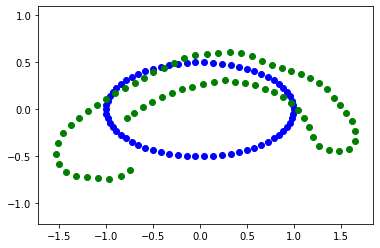

In [82]:
#defines an ellipse for initial conditions
def ellipse(cent, Amp): 
    return  np.vstack(( Amp[0]*np.cos(np.linspace(0,2*np.pi*(1-1./M.N.eval()),M.N.eval()))+cent[0], Amp[1]*np.sin(np.linspace(0,2*np.pi*(1-1./M.N.eval()),M.N.eval()))+cent[1] )).T

cent = [0.,0.]
Amp  = [1.,.5]
q = np.roll(np.flip(ellipse(cent,Amp),0),int(-M.N.eval()*.40),0).flatten()

M.N.set_value(N0)
avg_landmark_dist = np.mean(np.linalg.norm(qs.reshape((-1,M.N.eval(),M.m.eval()))[:,:-1]-qs.reshape((-1,M.N.eval(),M.m.eval()))[:,1:],axis=2))
sigma = .25 # in the order of avg_landmark_dist
M.k_sigma.set_value(np.diag((sigma,sigma)))
print("Sigma = ", M.k_sigma.get_value())

v = qs[16].flatten()

M.plot()
M.plotx(q[:140])
M.plotx(v[:140],color='g')
plt.show()

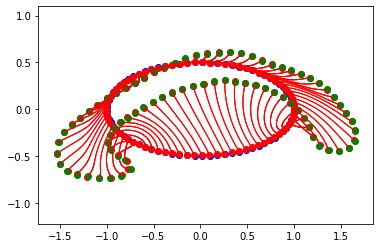

In [77]:
# Logarithm map
from src.Riemannian import Log
Log.initialize(M,f=M.Exp_Hamiltonian)

p_Log = M.Logf(q,v)[0]

qsv = M.Exp_Hamiltoniantf(q,p_Log).T
M.plot()
M.plotx(q)
M.plotx(qsv,color='r')
M.plotx(v,color='g')
plt.show()

# save
np.savez('match.npy',q0=q,v=v,p=p_Log)